/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


Solver status: optimal
Optimal value: 569.8296669909573
Average total reward over 20000 simulations: 568.07805
Number of pulls in dummy states (LP-based policy): 40565
Average total achieved value over 20000 simulations (Random policy): 555.4018
Average total achieved value over 20000 simulations (Not-Pull policy): 556.4573
Whittle Indices (including dummy states):
Average total achieved value over 20000 simulations (General Finite Whittle index policy): 568.17385
Whittle Indices (including dummy states):
Average total achieved value over 20000 simulations (General Whittle index policy): 568.44205


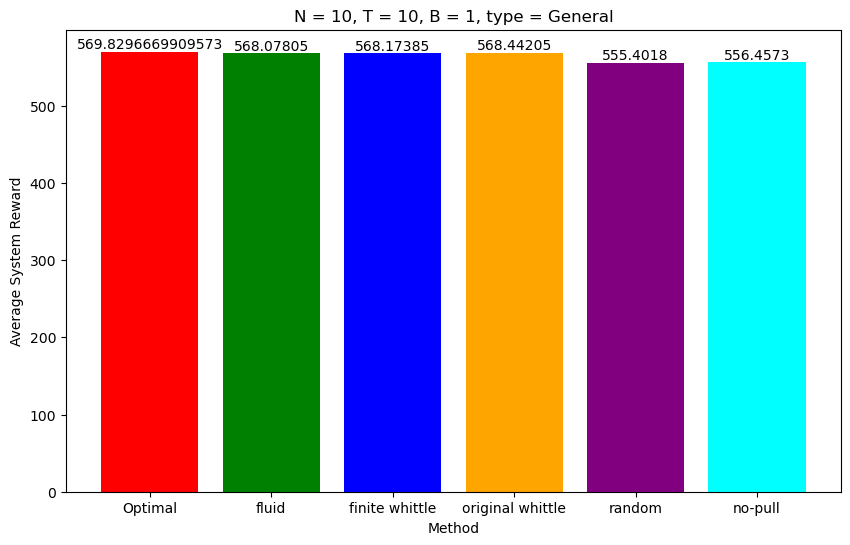

In [9]:
import cvxpy as cp
import numpy as np
from Whittle_index import *
from general_finite_whittle import *
from General_whittle_calculation import *

import matplotlib.pyplot as plt

# Define parameters
N = 10  # Number of arms
T = 10  # Time horizon
S = 10  # Number of non-dummy states (0 to 9)
S_prime = 2 * S  # Expanded state space with dummy states
A = 2  # Action space {0, 1}
K = 1  # Activation budget (number of arms to activate at each step)

# Define the reward function, from state 0 (reward 10) to state 9 (reward 1)
r = np.array(list(range(S, 0, -1)) + list(range(S, 0, -1)))  # Non-dummy and dummy states have the same rewards

#Generate general transition

def generate_general_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            # Action 0: Transition within S
            P[n, s, 0, :num_states] = np.random.dirichlet(np.ones(num_states))

            # Action 1: Transition to a dummy state
            P[n, s, 1, num_states:] = np.random.dirichlet(np.ones(num_dummy_states))

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            # Copy transitions from the corresponding normal state for action 0
            normal_state_index = s_a - num_states
            P[n, s_a, 0, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]  # Same for action 1

    return P

# Generate transition matrices

def generate_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            if s == 0:
                # Boundary condition for state 0:
                P[n, s, 1, s + S] = np.random.rand()  # Stay in state 0
                P[n, s, 1, s + S + 1] = 1 - P[n, s, 1, s + S]  # Move to state 1
            elif s == num_states - 1:
                # Boundary condition for state 9 (last state):
                P[n, s, 1, s + S - 1] = np.random.rand()  # Move to state 8
                P[n, s, 1, s + S] = 1 - P[n, s, 1, s + S - 1]  # Stay in state 9
            else:
                # General case for non-boundary states
                P[n, s, 1, s + S - 1] = np.random.rand()  # Move to s-1
                P[n, s, 1, s + S + 1] = 1 - P[n, s, 1, s + S - 1]  # Move to s+1

            # Action 0: No pull, move to s+1, unless it's the last state
            if s < num_states - 1:
                P[n, s, 0, s + 1] = 1.0  # Move to s+1 with probability 1
            else:
                P[n, s, 0, s] = 1.0  # Stay in state 9 if it's the last state

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            normal_state_index = s_a - num_states
            # Copy transitions from the corresponding normal state for action 0 within dummy states
            P[n, s_a, 0, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]

    return P



# Generate the transition matrix
P = generate_general_transition_matrix_with_dummy_states(N, S, S)


# Flatten the optimization variables
mu = cp.Variable(N * S_prime * A * T, nonneg=True)


# Helper function to get the index in the flattened mu
def mu_index(n, s, a, t):
    return n * S_prime * A * T + s * A * T + a * T + t


# Define objective function
objective = cp.Maximize(cp.sum([mu[mu_index(n, s, a, t)] * r[s]
                                for n in range(N)
                                for s in range(S_prime)
                                for a in range(A)
                                for t in range(T)]))

# Define constraints
constraints = []

# Activation budget constraint
for t in range(T):
    constraints.append(cp.sum([mu[mu_index(n, s, 1, t)]
                               for n in range(N)
                               for s in range(S_prime)]) <= K)

# Flow constraints for occupancy measure
for n in range(N):
    for t in range(1, T):
        for s in range(S_prime):
            constraints.append(cp.sum([mu[mu_index(n, s, a, t)] for a in range(A)]) ==
                               cp.sum([mu[mu_index(n, s_prime, a_prime, t - 1)] * P[n, s_prime, a_prime, s]
                                       for s_prime in range(S_prime)
                                       for a_prime in range(A)]))

# Initial distribution constraint (assuming uniform distribution here)
for n in range(N):
    for s in range(S):
        constraints.append(cp.sum([mu[mu_index(n, s, a, 0)] for a in range(A)]) == 1 / S)
        constraints.append(cp.sum([mu[mu_index(n, s + S, a, 0)] for a in range(A)]) == 0)

# Solve the problem
problem = cp.Problem(objective, constraints)
result = problem.solve(solver=cp.ECOS)  # Try using SCS or another solver

# Check solver status
print(f"Solver status: {problem.status}")
if problem.status in ["infeasible", "unbounded"]:
    print("The problem is infeasible or unbounded.")
else:
    # Display the optimal value
    print(f"Optimal value: {result}")

    # Recover and display the optimal policy
    optimal_mu = mu.value
    if optimal_mu is not None:
        optimal_mu_4D = optimal_mu.reshape((N, S_prime, A, T))

optimal_reward=result

# Monte Carlo simulation using the new setting
num_simulations = 20000
total_rewards = []
lp_pulls_in_dummy_states = 0
for sim in range(num_simulations):
    total_reward = 0
    arm_states = np.random.choice(range(S), N, p=[1 / S] * S)

    for t in range(T):
        # Precompute indices
        current_indices = []
        for n in range(N):
            current_state = arm_states[n]
            mu_1 = optimal_mu_4D[n, current_state, 1, t]
            mu_0 = optimal_mu_4D[n, current_state, 0, t]
            index_value = mu_1 / (mu_1 + mu_0) if (mu_1 + mu_0) > 0 else 0
            current_indices.append((n, current_state, index_value))

        current_indices.sort(key=lambda x: x[2], reverse=True)
        activated_arms = current_indices[:K]

        # Collect rewards and transition
        for n in range(N):
            total_reward += r[arm_states[n]]

        for arm in activated_arms:
            n, current_state, _ = arm
            if current_state >= S:  # Dummy states are indexed after normal states
                lp_pulls_in_dummy_states += 1
            next_state = np.random.choice(range(S_prime), p=P[n, current_state, 1, :])
            arm_states[n] = next_state

        for n in range(N):
            if n not in [arm[0] for arm in activated_arms]:
                current_state = arm_states[n]
                next_state = np.random.choice(range(S_prime), p=P[n, current_state, 0, :])
                arm_states[n] = next_state

    total_rewards.append(total_reward)

lp_average_reward = np.mean(total_rewards)
print(f"Average total reward over {num_simulations} simulations: {lp_average_reward}")
# Print counts of pulls in dummy states
print(f"Number of pulls in dummy states (LP-based policy): {lp_pulls_in_dummy_states}")


...
# Random Policy Benchmark
...
# Results storage for random policy
random_total_rewards = []
random_pulls_in_dummy_states = 0
# Monte Carlo simulations for random policy
for sim in range(num_simulations):
    # Initialize the total reward for this simulation
    random_total_reward = 0

    # Initialize the state of each arm randomly in one of the normal states
    arm_states = np.random.choice(range(S), N, p=[1/S] * S)  # Starting states for each arm
    #arm_states = np.ones(N,dtype=int)  # Starting states for each arm
    # Simulate the process for the entire time horizon T
    for t in range(T):
        # Random policy: randomly select K arms to activate
        random_arms = np.random.choice(range(N), K, replace=False)

        # Collect rewards for random policy for all arms before they transition
        for n in range(N):
            current_state = arm_states[n]
            random_total_reward += r[current_state]  # Reward is simply the state value

        # Update states for random policy
        for n in random_arms:
            current_state = arm_states[n]
            if current_state >= S:  # Dummy states are indexed after normal states
                random_pulls_in_dummy_states += 1
            # Move to the next state based on the transition probability for action 1
            next_state = np.random.choice(range(S_prime), p=P[n, current_state, 1, :])
            arm_states[n] = next_state  # Update the arm's state

        # For non-activated arms in random policy, transition based on action 0
        for n in range(N):
            if n not in random_arms:
                current_state = arm_states[n]
                # Move to the next state based on the transition probability for action 0
                next_state = np.random.choice(range(S_prime), p=P[n, current_state, 0, :])
                arm_states[n] = next_state  # Update the arm's state

    # Store the total rewards for this simulation
    random_total_rewards.append(random_total_reward)

# Calculate average total rewards for random policy
average_random_total_reward = np.mean(random_total_rewards)
print(f"Average total achieved value over {num_simulations} simulations (Random policy): {average_random_total_reward}")



...
# Not-pull Policy Benchmark
...
# Results storage for random policy
no_total_rewards = []
#no_pulls_in_dummy_states = 0
# Monte Carlo simulations for random policy
for sim in range(num_simulations):
    # Initialize the total reward for this simulation
    no_total_reward = 0

    # Initialize the state of each arm randomly in one of the normal states
    arm_states = np.random.choice(range(S), N, p=[1/S] * S)  # Starting states for each arm
    #arm_states = np.ones(N,dtype=int)  # Starting states for each arm
    # Simulate the process for the entire time horizon T
    for t in range(T):
        random_arms = np.random.choice(range(N), K, replace=False)

        # Collect rewards for random policy for all arms before they transition
        for n in range(N):
            current_state = arm_states[n]
            no_total_reward += r[current_state]

        # For non-activated arms in random policy, transition based on action 0
        for n in range(N):
            if n not in random_arms:
                current_state = arm_states[n]
                # Move to the next state based on the transition probability for action 0
                next_state = np.random.choice(range(S_prime), p=P[n, current_state, 0, :])
                arm_states[n] = next_state  # Update the arm's state

    # Store the total rewards for this simulation
    no_total_rewards.append(no_total_reward)

# Calculate average total rewards for no policy
average_no_total_reward = np.mean(no_total_rewards)
print(f"Average total achieved value over {num_simulations} simulations (Not-Pull policy): {average_no_total_reward}")

'''
...
#Simulate Whittle index
...
num_simulations = 20000
# Extract only normal states (excluding dummy states)
P_active_list = [P[n, :S, 1, S:2*S] for n in range(N)]
P_passive_list = [P[n, :S, 0, :S] for n in range(N)]

# Calculate Whittle index for normal states
whittle_indices = calculate_whittle_index(N, S, P_active_list, P_passive_list, list(range(S, 0, -1)))

# Set Whittle index for dummy states to zero
whittle_indices_full = np.zeros((N, S_prime))
whittle_indices_full[:, :S] = whittle_indices  # Set normal state Whittle indices
whittle_indices_full[:, S:] = 0  # Set dummy state Whittle indices to zero

# Output the Whittle indices(for Poisson)
print("Whittle Indices (including dummy states):")
#print(whittle_indices_full)

whittle_total_rewards = []
whittle_pulls_in_dummy_states = 0

for sim in range(num_simulations):
    total_reward = 0
    # Initialize the state of each arm in one of the normal states
    arm_states = np.random.choice(range(S), N, p=[1/S] * S)

    for t in range(T):
        # Get the current Whittle index values for each arm at the current states
        current_indices = []
        for n in range(N):
            current_state = arm_states[n]
            whittle_index_value = whittle_indices_full[n, current_state]
            current_indices.append((n, current_state, whittle_index_value))

        # Sort arms by their Whittle index values in descending order
        current_indices.sort(key=lambda x: x[2], reverse=True)

        # Select the top K arms to activate (i.e., pull)
        activated_arms = current_indices[:K]

        # Collect rewards for all arms before transition
        for n in range(N):
            total_reward += r[arm_states[n]]  # Reward is based on the current state

        # Update the states of activated arms based on action 1
        for arm in activated_arms:
            n, current_state, _ = arm
            next_state = np.random.choice(range(S_prime), p=P[n, current_state, 1, :])
            arm_states[n] = next_state

        # Update the states of non-activated arms based on action 0
        for n in range(N):
            if n not in [arm[0] for arm in activated_arms]:
                current_state = arm_states[n]
                next_state = np.random.choice(range(S_prime), p=P[n, current_state, 0, :])
                arm_states[n] = next_state

    # Store the total rewards for this simulation
    whittle_total_rewards.append(total_reward)

# Calculate the average total rewards for Whittle index policy
average_whittle_total_reward = np.mean(whittle_total_rewards)
print(f"Average total achieved value over {num_simulations} simulations (Whittle index policy): {average_whittle_total_reward}")
'''


...
#Simulate general infinite Whittle index
...
num_simulations = 20000

# Calculate Whittle index for normal states
general_whittle_indices = calculate_all_arm_finite_whittle(N, r, P, S_prime, T)

# Output the Whittle indices
print("Whittle Indices (including dummy states):")
#print(whittle_indices_full)

general_finite_whittle_total_rewards = []
#general_whittle_pulls_in_dummy_states = 0

for sim in range(num_simulations):
    total_reward = 0
    # Initialize the state of each arm in one of the normal states
    arm_states = np.random.choice(range(S), N, p=[1/S] * S)

    for t in range(T):
        # Get the current Whittle index values for each arm at the current states
        current_indices = []
        for n in range(N):
            current_state = arm_states[n]
            whittle_index_value = general_whittle_indices[n, t, current_state]
            current_indices.append((n, current_state, whittle_index_value))

        # Sort arms by their Whittle index values in descending order
        current_indices.sort(key=lambda x: x[2], reverse=True)

        # Select the top K arms to activate (i.e., pull)
        activated_arms = current_indices[:K]

        # Collect rewards for all arms before transition
        for n in range(N):
            total_reward += r[arm_states[n]]  # Reward is based on the current state

        # Update the states of activated arms based on action 1
        for arm in activated_arms:
            n, current_state, _ = arm
            next_state = np.random.choice(range(S_prime), p=P[n, current_state, 1, :])
            arm_states[n] = next_state

        # Update the states of non-activated arms based on action 0
        for n in range(N):
            if n not in [arm[0] for arm in activated_arms]:
                current_state = arm_states[n]
                next_state = np.random.choice(range(S_prime), p=P[n, current_state, 0, :])
                arm_states[n] = next_state

    # Store the total rewards for this simulation
    general_finite_whittle_total_rewards.append(total_reward)

# Calculate the average total rewards for Whittle index policy
average_general_finite_whittle_total_reward = np.mean(general_finite_whittle_total_rewards)
print(f"Average total achieved value over {num_simulations} simulations (General Finite Whittle index policy): {average_general_finite_whittle_total_reward}")



...
#Simulate general infinite Whittle index
...
num_simulations = 20000

# Calculate Whittle index for normal states
general_whittle_indices = calculate_all_arm_whittle(N, r, P, S_prime)

# Output the Whittle indices
print("Whittle Indices (including dummy states):")
#print(whittle_indices_full)

general_whittle_total_rewards = []
#general_whittle_pulls_in_dummy_states = 0

for sim in range(num_simulations):
    total_reward = 0
    # Initialize the state of each arm in one of the normal states
    arm_states = np.random.choice(range(S), N, p=[1/S] * S)

    for t in range(T):
        # Get the current Whittle index values for each arm at the current states
        current_indices = []
        for n in range(N):
            current_state = arm_states[n]
            whittle_index_value = general_whittle_indices[n, current_state]
            current_indices.append((n, current_state, whittle_index_value))

        # Sort arms by their Whittle index values in descending order
        current_indices.sort(key=lambda x: x[2], reverse=True)

        # Select the top K arms to activate (i.e., pull)
        activated_arms = current_indices[:K]

        # Collect rewards for all arms before transition
        for n in range(N):
            total_reward += r[arm_states[n]]  # Reward is based on the current state

        # Update the states of activated arms based on action 1
        for arm in activated_arms:
            n, current_state, _ = arm
            next_state = np.random.choice(range(S_prime), p=P[n, current_state, 1, :])
            arm_states[n] = next_state
        
        # Update the states of non-activated arms based on action 0
        for n in range(N):
            if n not in [arm[0] for arm in activated_arms]:
                current_state = arm_states[n]
                next_state = np.random.choice(range(S_prime), p=P[n, current_state, 0, :])
                arm_states[n] = next_state

    # Store the total rewards for this simulation
    general_whittle_total_rewards.append(total_reward)

# Calculate the average total rewards for Whittle index policy
average_general_whittle_total_reward = np.mean(general_whittle_total_rewards)
print(f"Average total achieved value over {num_simulations} simulations (General Whittle index policy): {average_general_whittle_total_reward}")


def plot_dictionary_data(data, N, T, B, type):
    """
    Generate a bar plot from a dictionary with unique colors and a legend.
    
    :param data: dict, a dictionary with key-value pairs where keys are labels and values are numeric.
    """
    # Define a list of colors; ensure there are enough colors for each bar
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']
    
    # Check if the dictionary has more elements than colors available
    if len(data) > len(colors):
        print("Warning: Not enough colors specified. Some bars will reuse colors.")
        # Extend the color list by repeating the initial list enough times
        colors *= (len(data) // len(colors) + 1)

    # Create a bar plot with different colors for each bar
    plt.figure(figsize=(10, 6))
    bars = plt.bar(data.keys(), data.values(), color=colors[:len(data)])  # Slice colors to match number of keys

    # Adding titles and labels
    plt.title(f'N = {N}, T = {T}, B = {B}, type = {type}')
    plt.xlabel('Method')
    plt.ylabel('Average System Reward')

    # Optional: Add value labels on top of each bar
    for key, value in zip(data.keys(), data.values()):
        plt.text(key, value, f'{value}', ha='center', va='bottom')

    # Show the plot
    
    #plt.show()
    plt.savefig(f'{type},N={N},T={T},B={B}.png')



experiment_synthetic_result = {
    "Optimal": optimal_reward,
    "fluid": lp_average_reward,
    "finite whittle": average_general_finite_whittle_total_reward,
    "original whittle": average_general_whittle_total_reward,
    "random": average_random_total_reward,
    "no-pull": average_no_total_reward
}

plot_dictionary_data(experiment_synthetic_result, N, T, K, "General")

In [7]:
import cvxpy as cp
import numpy as np
from Whittle_index import *
from general_finite_whittle import *

import matplotlib.pyplot as plt

# Define parameters
N = 10  # Number of arms
T = 10  # Time horizon
S = 10  # Number of non-dummy states (0 to 9)
S_prime = 2 * S  # Expanded state space with dummy states
A = 2  # Action space {0, 1}
K = 1  # Activation budget (number of arms to activate at each step)

# Define the reward function, from state 0 (reward 10) to state 9 (reward 1)
r = np.array(list(range(S, 0, -1)) + list(range(S, 0, -1)))  # Non-dummy and dummy states have the same rewards

...
#Simulate general infinite Whittle index
...
num_simulations = 20000

# Calculate Whittle index for normal states
general_whittle_indices = calculate_all_arm_finite_whittle(N, r, P, S_prime, T)

# Output the Whittle indices
print("Whittle Indices (including dummy states):")
#print(whittle_indices_full)

general_whittle_total_rewards = []
#general_whittle_pulls_in_dummy_states = 0

for sim in range(num_simulations):
    total_reward = 0
    # Initialize the state of each arm in one of the normal states
    arm_states = np.random.choice(range(S), N, p=[1/S] * S)

    for t in range(T):
        # Get the current Whittle index values for each arm at the current states
        current_indices = []
        for n in range(N):
            current_state = arm_states[n]
            # print(f"the current n is {n}")
            # print(f"the current t is {t}")
            # print(f'value of current_state is {current_state}')
            # print(f'shape of matrix is {general_whittle_indices.shape}')
            whittle_index_value = general_whittle_indices[n, t, current_state]
            current_indices.append((n, current_state, whittle_index_value))

        # Sort arms by their Whittle index values in descending order
        current_indices.sort(key=lambda x: x[2], reverse=True)

        # Select the top K arms to activate (i.e., pull)
        activated_arms = current_indices[:K]

        # Collect rewards for all arms before transition
        for n in range(N):
            total_reward += r[arm_states[n]]  # Reward is based on the current state

        # Update the states of activated arms based on action 1
        for arm in activated_arms:
            n, current_state, _ = arm
            next_state = np.random.choice(range(S_prime), p=P[n, current_state, 1, :])
            arm_states[n] = next_state

        # Update the states of non-activated arms based on action 0
        for n in range(N):
            if n not in [arm[0] for arm in activated_arms]:
                current_state = arm_states[n]
                next_state = np.random.choice(range(S_prime), p=P[n, current_state, 0, :])
                arm_states[n] = next_state

    # Store the total rewards for this simulation
    general_whittle_total_rewards.append(total_reward)

# Calculate the average total rewards for Whittle index policy
average_general_whittle_total_reward = np.mean(general_whittle_total_rewards)
print(f"Average total achieved value over {num_simulations} simulations (General Whittle index policy): {average_general_whittle_total_reward}")



Whittle Indices (including dummy states):
Average total achieved value over 20000 simulations (General Whittle index policy): 552.5589
